# <center>A/B experiment analysis of a game</center>

### <center>Author: Adriana Vega</center>

### Tl,DR

This is a summary of the analysis of the experiment (A/B test) on a game offering two different game experiences to players, which was ran from 2017-05-04 to 2017-05-22. The key takeaways of this analysis are:

- Players in version B of the game (test group) on average make 5,2% more purchases comparing to group A.
- Players in version B of the game play 1,7% less rounds comparing to version A of the game.
- There is no statistical significance in the number of days played between the two groups.

Based on the result, I would recommend to put version B full on as we would increase our revenue since the average purchases are higher for players in B. 

 


In [569]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats
from math import ceil, floor
from itertools import product
%matplotlib inline


## Problem statement

Considering a fictional mobile game. Like other some games, players need to beat levels to progress
through a map. At every level, players are faced with a math question they need to answer correctly to pass
to the next level. The game is Free to Play meaning that players can download and play the game for free
but can optionally buy hints on the levels.
In 2017 we ran an experiment (A/B Test) on the game, offering two different game experiences that we
call A and B, group A being the control group where the experience is kept as is, and group B being
the experiment group that is exposed to the new experience. We set the assignment process to randomly
distribute players among the groups: 80% to group A (control) and 20% to group B (test). The experiment
ran from 2017-05-04 to 2017-05-22.

We need to analyse and summarise the data provided, to determine which of the 2 experiences makes a better game. 

## Data preparation

The first step is to run the following query through the BigQuery GUI and then save the results as a csv to latter on import in this notobook.

The variables included in the table are:

- playerid: Unique numeric identifier for each player

- abtest_group: The group the player was assigned to (A or B)

- nr_rounds: Total number of game rounds played during the experiment

- avg_rounds: Average game rounds by player during the experiment 

- days_played: Days played during the experiment

- nr_purchases: Total number of purchases during the experiment

- avg_purchases: Average number of purchases per player during the experiment 



In [ ]:
'''
SELECT
a.playerid
, a.abtest_group
, a.nr_rounds
, round(a.avg_rounds,2) AS avg_rounds
, a.days_played
, a.nr_purchases
, round(a.avg_purchases,2) AS avg_purchases


FROM(
SELECT
  act.playerid
  , assi.abtest_group AS abtest_group
  , sum(act.gameends) AS nr_rounds
  , avg(act.gameends) AS avg_rounds
  , sum(act.purchases) AS nr_purchases
  , avg(act.purchases) AS avg_purchases
  , count(act.activity_date) AS days_played


FROM `king-ds-recruit-candidate-327.abtest.assignment` assi
JOIN `king-ds-recruit-candidate-327.abtest.activity` AS act

  ON act.playerid= assi.playerid  

WHERE
assi.assignment_date BETWEEN '2017-05-04' AND '2017-05-22' 
AND
act.activity_date BETWEEN '2017-05-04' AND '2017-05-22' 

GROUP BY 1,2

) a

'''

In [50]:
# Import the csv file generated from the previous query 
df_abtest = pd.read_csv('bq_results.csv')

The randomly assignment of players among the groups was 80% to group A (control) and 20% to group B (test)


In [583]:
df_abtest.groupby('abtest_group')['playerid'].nunique()

abtest_group
A    8265610
B    2065446
Name: playerid, dtype: int64

To balance the number of players of both groups, I randomly selected the same amount of players from group A 

In [60]:
df_sample_a = df_abtest[df_abtest.abtest_group=='A'].sample(n=df_abtest[df_abtest.abtest_group=='B'].shape[0], random_state=123)

#Concat the sample of group A with all the players in group B
df_final = pd.concat([df_sample_a ,df_abtest[df_abtest.abtest_group=='B']])

We now have a df with similar numbers of players in both group A and group B. 


In [584]:
df_final.groupby('abtest_group')['playerid'].nunique()

abtest_group
A    2065446
B    2065446
Name: playerid, dtype: int64

##  Procedure


1. Data validation 

    - Similar size of the groups
    
    - Each player assigned to only one experiment group
    
    - Nan values
    
    - Outliers
    

2. EDA

    - Distribution and descriptive statistics of the variables
    
 
3. T-test results

    - Metrics
    
    - Check t-test assumptions 

    - A/B test results
    
    - Do different types of players react differently to the treatment


4. Final results

## 1. Data validation

What is the percentage of players in the experiemnt that is in each group?


In [585]:
groupA_ratio = round(df_final[df_final.abtest_group=='A'].playerid.nunique() / df_final.playerid.nunique(),2)
print(f"Percentage of players that are in group A (control) {groupA_ratio*100}%")

Percentage of players that are in group A (control) 50.0%


Check if each player is assigned to one experiment group only

In [586]:
df_final.groupby(['playerid'])['abtest_group'].nunique().sum() / df_final.shape[0]

1.0

Check na values

In [587]:
print(df_final[df_final.isnull()].count())
print(df_final[df_final.isna()].count())

playerid         0
abtest_group     0
nr_rounds        0
avg_rounds       0
days_played      0
nr_purchases     0
avg_purchases    0
converted        0
rounds_bins      0
days_bins        0
dtype: int64
playerid         0
abtest_group     0
nr_rounds        0
avg_rounds       0
days_played      0
nr_purchases     0
avg_purchases    0
converted        0
rounds_bins      0
days_bins        0
dtype: int64


Create a boxplot_grid function to check the presence of outliers

In [588]:
def boxplot_grid(columns_to_plot, comparison_variable, data_frame, title, figsize):
    """
    Outputs a figure including a boxplot for each of the columns specified in columns_to_plot
    separated by the comparison_variable
    
    IN:
    columns_to_plot (list): continuous variables to be plotted, must be in data_frame
    comparison_variable (string): variable name of comparison variable
    data_frame (pandas df): DF including columns_to_plot and comparison_variable
    title (str): Title of plot
    figsize (tuple): Size of figure
    
    OUT:
    Grid Figure inluding boxplot for each variable in columns_to_plot
    """
    
    nr_rows = ceil(len(columns_to_plot)/2)
    counter=0
    fig, axes = plt.subplots(ncols=2, nrows=nr_rows, figsize=figsize)

    for i, j in product(range(nr_rows),  repeat=2):
        if counter < len(columns_to_plot):
            ax = sns.boxplot(x=comparison_variable
                             , y=columns_to_plot[counter]
                             , data=data_frame
                             , orient='v'
                             , ax=axes[j, i])
            if counter <= len(columns_to_plot):
                counter+=1
        else:
            break
    if len(columns_to_plot) % 2 > 0:
        fig.delaxes(axes[nr_rows-1][1])
    fig.suptitle(title, fontsize=(18), y=0.91)

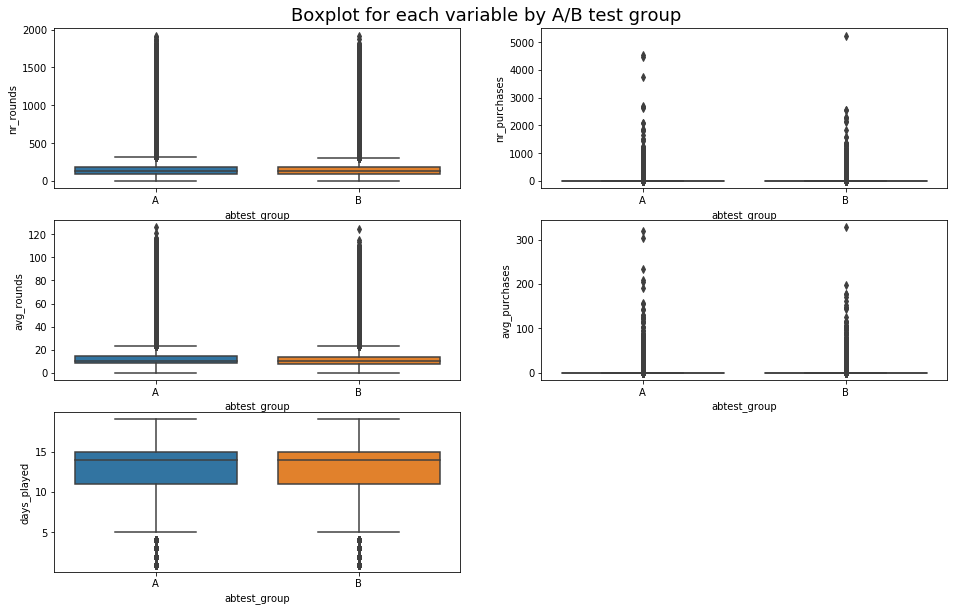

In [589]:
boxplot_grid(columns_to_plot=['nr_rounds', 'avg_rounds', 'days_played', 'nr_purchases', 'avg_purchases']
             , comparison_variable='abtest_group'
             , data_frame=df_final
             , title='Boxplot for each variable by A/B test group'
             , figsize=(16,10)
            )

Check percentage of number of purchases with zeros across the whole sample and for each test group


In [590]:
# Whole Sample
(df_final[df_final.nr_purchases==0].shape[0]) / df_final.shape[0]

0.9730477097924612

In [603]:
# Group A
(df_final[(df_final.nr_purchases==0)&(df_final.abtest_group=='A')].shape[0]) / df_final[(df_final.abtest_group=='A')].shape[0]

0.9729864639404758

In [604]:
# Group B
(df_final[(df_final.nr_purchases==0)&(df_final.abtest_group=='B')].shape[0]) / df_final[(df_final.abtest_group=='B')].shape[0]

0.9731089556444468

The above plots show that there are outliers (following the boxplot definition of outliers) for each variable in analysis. They are present in both the control and test groups. So, it is interesting to see that both groups show similar patterns when it comes to extreme values.   

Considering the special case of number of purchases and avg number of purchases, it seem that every observation which is greatter than 0 is classified as an outlier or extreme value. This is due to the high number of zeros in the data set (around 97%).

Considering the days played in the experiment, we see that the game patterns in the control and test group are similar, which suggest a valid A/B testing environment.

## 2. EDA

#### Do the control and test groups have similar caracteristics

I want to get a better understanding of the distribution of all the features separated by test groups. 



In [369]:
def describe_features(df, col, group_col):
    """
    Plot the distribution of a feature for group A (control) and group B (test) separately. 
    Additionally, print out some statistical features of the distribution.
    
    Keywords:
    df: df including the feature and the group variable (A,B)
    col : column name of the feature
    """
    fig, ax = plt.subplots(figsize=(10,6))
    dict_status_stats = {}
    for value in df[group_col].unique():
        if value=='A':
            label='Group A (control)'
        else:
            label='Group B (test)'
        sns.distplot(df[(df[group_col]==value)][col]
                 , label=label
                 , bins=20
                 , ax=ax
                )
        mean = df[(df[group_col]==value)][col].mean()
        median = df[(df[group_col]==value)][col].median()
        std = df[(df[group_col]==value)][col].std()
        dict_status_stats[label] = mean, median, std
        sample = df[(df[group_col]==value)][col]
        
    ax.set_title(f"{col} Distribution for Group A (control) and Group B (test)", fontsize=16)
    ax.set_ylabel("Denisty", fontsize=14)
    ax.set_xlabel(f"{col}", fontsize=14)
    plt.legend()
    plt.show()
    for label in dict_status_stats.keys():
        print(f"{len(col)*str('*')}")
        print(f"{col}: {label}")
        print(f"Mean:{round(dict_status_stats[label][0],3)}")
        print(f"Median:{round(dict_status_stats[label][1],3)}")
        print(f"Std:{round(dict_status_stats[label][2],3)}")
    

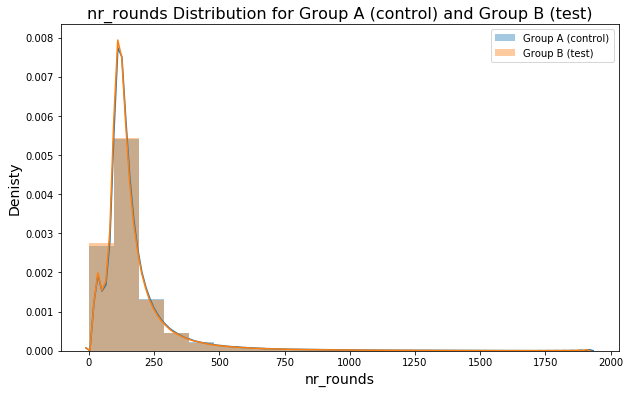

*********
nr_rounds: Group A (control)
Mean:158.562
Median:129.0
Std:139.844
*********
nr_rounds: Group B (test)
Mean:155.49
Median:127.0
Std:136.897


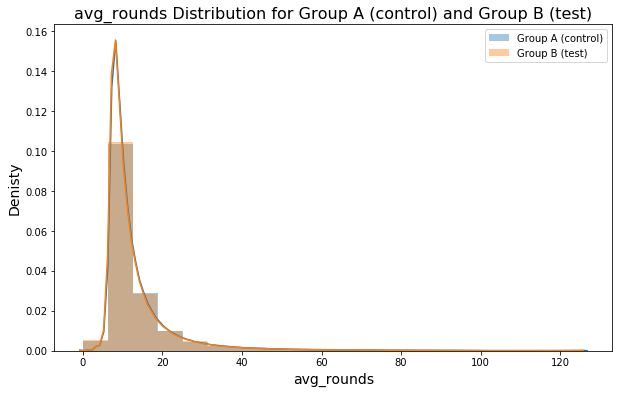

**********
avg_rounds: Group A (control)
Mean:13.178
Median:10.0
Std:9.686
**********
avg_rounds: Group B (test)
Mean:12.949
Median:9.93
Std:9.506


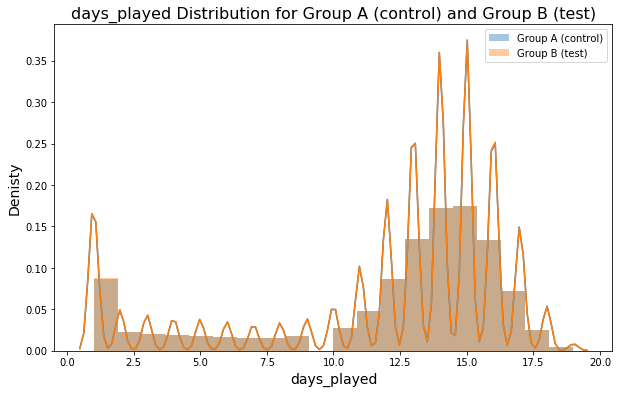

***********
days_played: Group A (control)
Mean:12.029
Median:14.0
Std:4.796
***********
days_played: Group B (test)
Mean:12.023
Median:14.0
Std:4.799


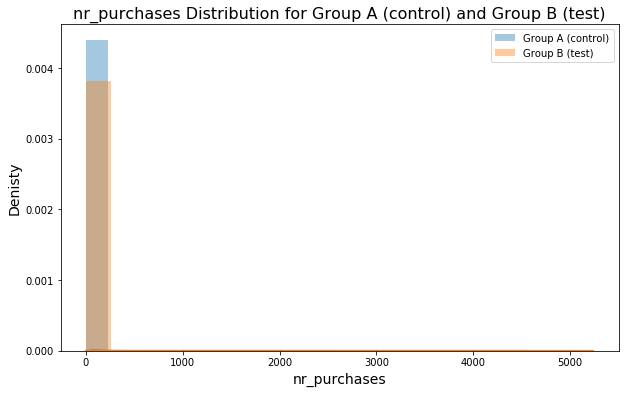

************
nr_purchases: Group A (control)
Mean:0.369
Median:0.0
Std:9.827
************
nr_purchases: Group B (test)
Mean:0.393
Median:0.0
Std:9.72


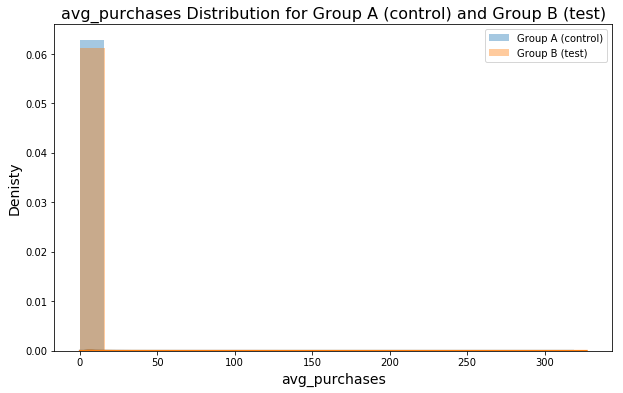

*************
avg_purchases: Group A (control)
Mean:0.031
Median:0.0
Std:0.766
*************
avg_purchases: Group B (test)
Mean:0.033
Median:0.0
Std:0.753


In [370]:
# For every feature apply describe_features fucntion
for col in ['nr_rounds', 'avg_rounds', 'days_played', 'nr_purchases', 'avg_purchases']:
    describe_features(df=df_final, col=col, group_col='abtest_group')

#### Brief comments of each variable

- nr_rounds: the distributions of both groups visualy seem to be very similar with a long tail on the right. Suggesting that there are few players playing extensively. This fact is present in group A and B, however the mean number of rounds per player is different in both groups, which we will test latter on.  


- avg_rounds: same results as nr_rounds


- days_played: the destributions of both groups seem to have similar patterns. We can see that some players (right tail) just play a few days compared to their means.  


- nr_purchases: It is not surprising that the distribution of the number of players is concentrated in 0 for both the control and test group, as we already observed it in the previous boxplots.


- avg_purchases: same results as nr_purchases

#### Create round bins and compare with the average purchase per player

In [591]:
# Create 4 bins based on the quartiles of number of game rounds of each group 
labels = ['Q1', 'Q2', 'Q3', 'Q4']
df_final['rounds_bins'] = (df_final.groupby(['abtest_group'])['nr_rounds']
                           .transform(lambda x: pd.qcut(x, q=4, labels=labels)))


Text(0.5, 0, 'Rounds Bin ')

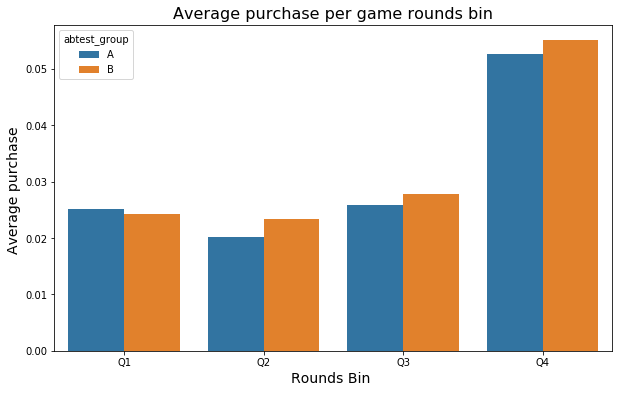

In [592]:
fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x='rounds_bins', y='avg_purchases', 
            hue='abtest_group',
            data=df_final.groupby(['rounds_bins', 'abtest_group'])['avg_purchases'].mean().reset_index())

ax.set_title("Average purchase per game rounds bin", fontsize=16)
ax.set_ylabel("Average purchase ", fontsize=14)
ax.set_xlabel("Rounds Bin ", fontsize=14)

it seems that players that pass more rounds are more prone to make a purchase in the test group except for the the first quartile. Suggesting that the intervention affects players who are more engaged (measured by the amount of rounds they played during the experiment)

#### Create days bins and compare with average purchase per player

In [594]:
# Create 4 bins based on the quartiles of days played of each group 
df_final['days_bins'] = df_final.groupby(['abtest_group'])['days_played'].transform(lambda x: pd.qcut(x, q=4, labels=labels))

Text(0.5, 0, 'Days Bin ')

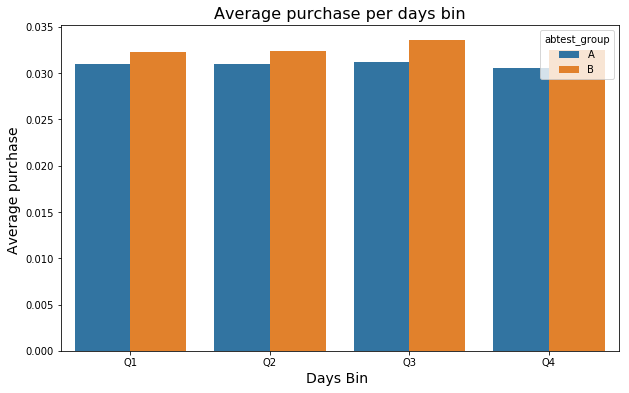

In [595]:
fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x='days_bins', y='avg_purchases', hue='abtest_group',data=df_final.groupby(['days_bins', 'abtest_group'])['avg_purchases'].mean().reset_index())

ax.set_title("Average purchase per days bin", fontsize=16)
ax.set_ylabel("Average purchase ", fontsize=14)
ax.set_xlabel("Days Bin ", fontsize=14)

it seems that independently of the number of days played, players in the control group have a lower average number of purchase compared to the test group. 


## 3. T-test results

1. Metrics that we are interested to compare between the control and test group

    - Average number of purchase per player for each group
    - Average gamerounds per player for each group
    - Average number of days played for each group 


2. t-test assumptions

    The assumptions that the data must meet in order for the test results to be valid are:
    
    - The samples are independently and randomly drawn
    - The sample sizes are the same: n1 = n2 = n
    - Noramilty of the underlying test distribution
    
__Note to normality assumption of the t-test:__ As our sample size is large and thanks to the central limit theorem we can savely perform our t-test. This could be proven if we would apply bootstrapping (random sampling with replacement) to our test statistic


    

3. Apply t-test for each metric




Show the mean differnce of the 3 metrics in the summary table for group A and group B


In [597]:
df_results_summary = df_abtest.groupby(['abtest_group'], as_index=False).agg({'avg_rounds' : 'mean',
                                                                              'days_played' : 'mean',
                                                                              'avg_purchases' : 'mean'
                                                                             })

df_results_summary

abtest_group  avg_rounds  days_played  avg_purchases
0            A   13.182791    12.028104       0.030649
1            B   12.949119    12.023382       0.032559

In [599]:
# Create a function to present the results of the ttest
def perform_ttest(df, col, group_column, groups): 
    
    results_ttest = ttest_ind(a=df[df[group_column]==groups[0]][col]
                              , b=df[df[group_column]==groups[1]][col]
                              , equal_var=False)
    
    difference = np.mean(df[df[group_column]==groups[1]][col]) - np.mean(df[df[group_column]==groups[0]][col])
    relative_diff = difference / np.mean(df[df[group_column]==groups[0]][col])*100
    print(f"Difference in Means between {groups[0]} and {groups[1]} for metric {col}: ")
    print(f"Absolute: {round(difference,4)}")
    print(f"Relative to group {groups[0]}: {round(relative_diff,3)}%")
    print(f"""Result of t-Test for equality of means:\
    \nt-statistic: {round(results_ttest[0],2)} \np-value:{np.round(results_ttest[1],3)}""")
    print(f"Results stat. significant at CI 95%: {results_ttest[1]<=0.05}")

### Average number of purchases per player

The hypothesis to test are:

Ho: "the mean number of purchases is the same for the two groups"
    
H1: "the means are different "


In [598]:
# Apply perform_ttest function on the average number of purchase.
perform_ttest(df=df_final, col='avg_purchases', group_column='abtest_group', groups=['A', 'B'])

Difference in Means between A and B for metric avg_purchases: 
Absolute: 0.0016
Relative to group A: 5.211%
Result of t-Test for equality of means:    
t-statistic: -2.16 
p-value:0.031
Results stat. significant at CI 95%: True


We reject the null hypothesis, therefore there is a statistical significant difference in the average number of purchases per player between the 2 groups. On average a player of the test group (B) makes 0.0016 more puchases than a player in the control group (A) in absolute numbers. This means that players that were exposed to the new experience of the game on average bought 5,2% more in relative terms comparing to those that did not see the new experience.

### Average number of game rounds per player 

The hypothesis to test are:

Ho: "the mean number of game rounds per player is the same for the two groups"
    
H1: "the means are different "


In [600]:
# Apply perform_ttest function on the average number of game rounds.
perform_ttest(df=df_final, col='avg_rounds', group_column='abtest_group', groups=['A', 'B'])

Difference in Means between A and B for metric avg_rounds: 
Absolute: -0.2292
Relative to group A: -1.739%
Result of t-Test for equality of means:    
t-statistic: 24.27 
p-value:0.0
Results stat. significant at CI 95%: True


We reject the null hypothesis, therefore there is a statistical significant difference in the average number of game rounds between the 2 groups. On average a player of the test group (B) plays 0,229 less rounds than a player in the control group (A) in absolute numbers. This means that players that were exposed to the new experience of the game on average play 1,7% less in relative terms comparing to those that did not see the new experience.



### Average days played per player 

The hypothesis to test are:

Ho: "the mean number of days played is the same for the two groups"
    
H1: "the means are different "


In [601]:
# Apply perform_ttest function on the number of days played .
perform_ttest(df=df_final, col='days_played', group_column='abtest_group', groups=['A', 'B'])

Difference in Means between A and B for metric days_played: 
Absolute: -0.0056
Relative to group A: -0.047%
Result of t-Test for equality of means:    
t-statistic: 1.19 
p-value:0.236
Results stat. significant at CI 95%: False


We do not reject the null hypothesis that both means are equal in when it comes to the number of days played by players between the two groups. Regarding to playing patterns i.e. starting a game there seems to be no difference between group A and B, which suggests a good experiment set up. 

### Do different types of players react differently to the treatment (Cohort analysis)

I will analyse if there are different patterns related to the average number of purchase per player within each cohort. A cohort here is defined by the quartiles related to the amount of rounds a player passes during the experiment timeframe. Thereby we split players in bins of low engaged and up to high-engaged individuals.  

In [449]:
# Avg purchases per group
df_final.groupby(['abtest_group','rounds_bins'])['avg_purchases'].mean()

abtest_group  rounds_bins
A             Q1             0.025220
              Q2             0.020197
              Q3             0.025873
              Q4             0.052548
B             Q1             0.024304
              Q2             0.023278
              Q3             0.027780
              Q4             0.055057
Name: avg_purchases, dtype: float64

In [393]:
cohorts =  ['Q1','Q2','Q3','Q4']

In [407]:
for cohort in cohorts:
    print("="*20)
    print(cohort)
    perform_ttest(df=df_final[df_final.rounds_bins==cohort]
                  , col='avg_purchases'
                  , group_column='abtest_group'
                  , groups=['A', 'B'])
    

Q1
Difference in Means between A and B for metric avg_purchases: 
Absolute: -0.0009
Relative to group A: -3.632%
Result of t-Test for equality of means:    
t-statistic: 0.77 
p-value:0.442
Results stat. significant at CI 95%: False
Q2
Difference in Means between A and B for metric avg_purchases: 
Absolute: 0.0031
Relative to group A: 15.254%
Result of t-Test for equality of means:    
t-statistic: -3.01 
p-value:0.003
Results stat. significant at CI 95%: True
Q3
Difference in Means between A and B for metric avg_purchases: 
Absolute: 0.0019
Relative to group A: 7.372%
Result of t-Test for equality of means:    
t-statistic: -1.78 
p-value:0.075
Results stat. significant at CI 95%: False
Q4
Difference in Means between A and B for metric avg_purchases: 
Absolute: 0.0025
Relative to group A: 4.776%
Result of t-Test for equality of means:    
t-statistic: -1.09 
p-value:0.278
Results stat. significant at CI 95%: False


The results of the t-tests of the difference in the average number of purchases for the control and test group for each cohort show very interesting results. 

On one hand we see that there is no statistical difference in the average number of purchases between the 2 groups for players in the first and fourth quartile. On the other hand, players exposed to the new version of the game (group B) on average have higher purchases (around 15% more with CI 95% in Q2 and 8% more with CI 90% in Q3).


## 5. Final results

Based on the above t-test results we can conclude that players in version B of the game (test group) on average make 5,2% more purchases and play 1,7% less rounds comparing to version A of the game.

At first glance these results seem to be counter-intuitive as you would suspect that players who are playing more are also buying more. 

One possible intervention which would lead to the above described customer behavior, however, could be of the following kind.


#### Possible game set-up and intervention

Players in the game have a fixed amount of free clues/hints. Once these free clues are used up a player has the option to buy aditional clues in order to progress to the next round in case he/she is not able to solve the posed problem.

In our control group (A) a player has 5 of these clues/hints and afterwards he/she can buy additional clues. On the other hand, in our variant (B) players only get 3 free clues and any additional clue has to be bought. This intervention could lead to the consumer behavior we are observing in this dataset. (Note: 5 and 3 are examples used for clarification).

Hence, players in group A will play more rounds since they have more clues available and most players are not buying any clues at all. On the other side, players who are prone to buying in group B are buying more on average per player as players that are prone to buying in group A as they have fewer clues. 


Based on the result, I would recommend to put version B full on as we would increase our revenue since the average puchases are higher for players in B. However, I would recommend to have a hold out group which should not be part of epxerimentation to examine long term effects of new product launches.





### Further suggestions for analysis 

One further analysis could be to compare if there exists any pre-experiment bias. This could be done by comparing our key metrics (avg purchases and avg rounds per player) before the intervention took place for our two groups. In a valid experiment set-up we should not be able to detect any difference between the two groups prior to the experiment.  

## Appendix

Show case central limit theorem in action:

Prove of normality assumption on large sample with bootstrapping (random sampling with replacement) to our test statistic 


In [605]:
def get_boostrap_mean(df, group, group_col, col, sims, ci=0.95, verbose=False):

    mean_lengths, sims = [], sims
    for i in range(sims):
        df_sample = df[df[group_col]==group][col].sample(n=df[df[group_col]==group].shape[0], replace=True)
        sample_mean = np.mean(df_sample)
        mean_lengths.append(sample_mean)

    # Calculate bootstrapped mean and 95% confidence interval.
    lower, upper = (1-ci)/2, ci + ((1-ci)/2) 
    boot_mean = np.mean(mean_lengths)
    boot_95_ci = np.percentile(mean_lengths, [lower*100, upper*100])
    if verbose==True:
        print("Bootstrapped Mean  = {}, 95% CI = {}".format(boot_mean, boot_95_ci))
    
    return mean_lengths, [boot_mean, boot_95_ci]

Apply get_bootstrap_mean in the average number of purchases of group A and B 

Takes time to run!


In [606]:
means_A, stats_test_A = get_boostrap_mean(df=df_final, group='A', 
                                          group_col='abtest_group',col='avg_purchases', sims=1000)

In [608]:
means_B, stats_test_B = get_boostrap_mean(df=df_final, group='B', 
                                          group_col='abtest_group',col='avg_purchases', sims=1000)

Distribution of the bootstraped means of avg_purchases of A and B 

Reject Null-Hypothesis of Normality: False


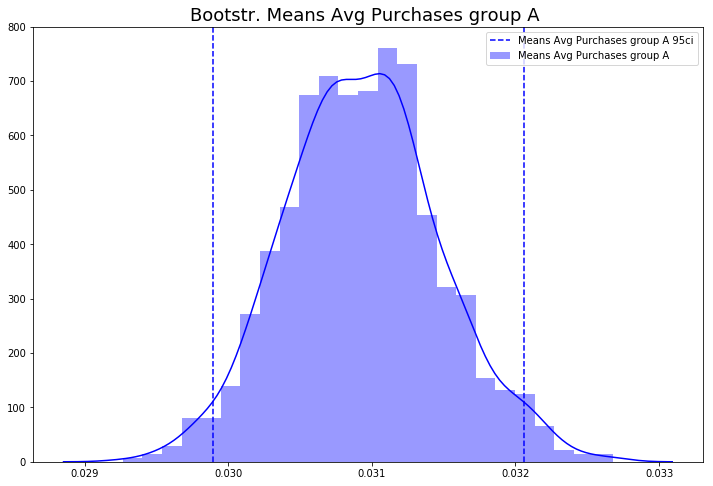

In [611]:
print(f"Reject Null-Hypothesis of Normality: {stats.shapiro(np.array(means_A))[1] <= 0.05}")
fig, ax = plt.subplots(figsize=(12,8))
for counter, algo in enumerate([[means_A, stats_test_A]]):
    color_map = ['blue']
    labels=['Means Avg Purchases group A']
    sns.distplot(algo[0], ax=ax, color=color_map[counter], label=labels[counter])
    ax.axvline(algo[1][1][0], color=color_map[counter], label=labels[counter]+" 95ci", linestyle='--')
    ax.axvline(algo[1][1][1], color=color_map[counter], linestyle='--')
plt.title("Bootstr. Means Avg Purchases group A ", fontsize=18)
plt.legend()

Reject Null-Hypothesis of Normality: False


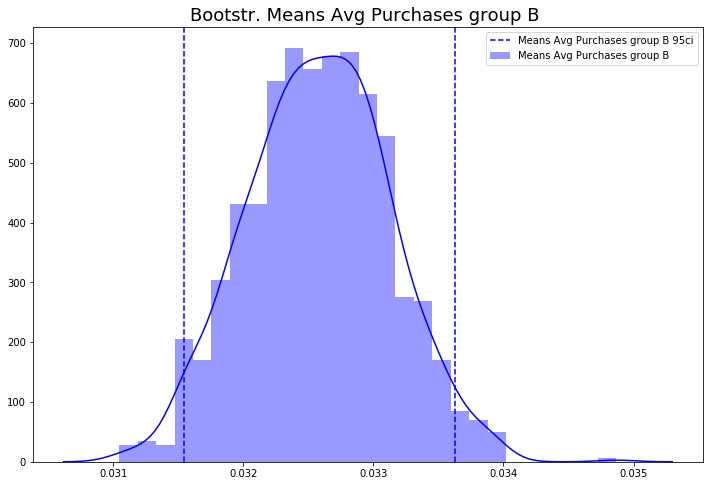

In [612]:
print(f"Reject Null-Hypothesis of Normality: {stats.shapiro(np.array(means_B))[1] <= 0.05}")
fig, ax = plt.subplots(figsize=(12,8))
for counter, algo in enumerate([[means_B, stats_test_B]]):
    color_map = ['blue']
    labels=['Means Avg Purchases group B']
    sns.distplot(algo[0], ax=ax, color=color_map[counter], label=labels[counter])
    ax.axvline(algo[1][1][0], color=color_map[counter], label=labels[counter]+" 95ci", linestyle='--')
    ax.axvline(algo[1][1][1], color=color_map[counter], linestyle='--')
plt.title("Bootstr. Means Avg Purchases group B ", fontsize=18)
plt.legend()

Test distributions are normally distributed!